In [1]:
# standing data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

# sklearn
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
# persistence
from sklearn.externals import joblib

from TDPPredictor import *

%matplotlib inline

In [2]:
Tag='Results'
outdir='fig/'+Tag
import os
os.system('mkdir -p '+outdir)
#Load the dataset
data=pd.read_csv('../data/round2/batch2_all_viable_merged_v2.csv')
setup_df(data)                 
data.info()

before conversion: 28401
after conversion: 473.35
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 53 columns):
Unnamed: 0       3050 non-null int64
File             3050 non-null object
Output           3050 non-null object
Cura Setting     3050 non-null object
dh               3050 non-null float64
t                3050 non-null float64
Vfil             3050 non-null float64
Vsup             3050 non-null float64
Load Time        3050 non-null float64
File Size        3050 non-null int64
Time             3050 non-null float64
Watertight       3050 non-null bool
Time.1           3050 non-null float64
NumBodies        3050 non-null float64
Time.2           3050 non-null float64
minZ             3050 non-null float64
Time.3           3050 non-null float64
X                3050 non-null float64
Y                3050 non-null float64
Z                3050 non-null float64
Time.4           3050 non-null float64
Vmes             3050 non-null flo

In [3]:
#filter dataset
Vmin=1.
Vmax=2000.
anafilter=(data['Vmes']>Vmin)&(data['Vmes']<Vmax)&(data['Watertight']==True)
sd=data[anafilter]

# cut numbers
ndata=len(data)
nselected=len(sd)
ntrain=np.int(nselected*0.6)
nval=np.int(nselected*0.3)
print 'total input:', ndata, 'total selected:', nselected, 'selection efficiency:', np.divide(nselected,np.float(ndata))
# test first on the training set
sd_test_train = sd.head(ntrain+nval)
sd_train = sd_test_train.head(ntrain)
sd_test = sd_test_train.tail(nval)
print 'train on:',len(sd_train), 'testing on:',len(sd_test)

total input: 3050 total selected: 3038 selection efficiency: 0.99606557377
train on: 1822 testing on: 911


In [4]:
sd_train[['t','Vfil','Vsup','sumV','Vmes','Vbb','Vch','Sa','Z','rSaVmes','rVbbVmes','rVchVmes','Vangover']].corr()

,t,Vfil,Vsup,sumV,Vmes,Vbb,Vch,Sa,Z,rSaVmes,rVbbVmes,rVchVmes,Vangover
t,1.000000,0.731170,0.757996,0.985809,0.696076,0.652653,0.666812,0.559169,0.401319,-0.185031,0.007033,0.030843,0.462097
Vfil,0.731170,1.000000,0.113160,0.830461,0.962030,0.684058,0.683538,0.600305,0.450621,-0.269297,-0.080810,-0.085153,0.264528
Vsup,0.757996,0.113160,1.000000,0.647473,0.100064,0.263596,0.279585,0.191505,0.117129,-0.018245,0.072667,0.101885,0.392042
sumV,0.985809,0.830461,0.647473,1.000000,0.793995,0.672475,0.681041,0.567816,0.411304,-0.216784,-0.021240,-0.008189,0.422706
Vmes,0.696076,0.962030,0.100064,0.793995,1.000000,0.696310,0.683988,0.599424,0.458004,-0.270555,-0.083200,-0.090378,0.265489
Vbb,0.652653,0.684058,0.263596,0.672475,0.696310,1.000000,0.918530,0.792680,0.594044,-0.123221,0.268548,0.301817,0.530236
Vch,0.666812,0.683538,0.279585,0.681041,0.683988,0.918530,1.000000,0.863465,0.544688,-0.114844,0.177089,0.283573,0.536702
Sa,0.559169,0.600305,0.191505,0.567816,0.599424,0.792680,0.863465,1.000000,0.504484,-0.031730,0.081687,0.187540,0.502332
Z,0.401319,0.450621,0.117129,0.411304,0.458004,0.594044,0.544688,0.504484,1.000000,-0.179573,0.157062,0.167578,0.402033
rSaVmes,-0.185031,-0.269297,-0.018245,-0.216784,-0.270555,-0.123221,-0.114844,-0.031730,-0.179573,1.000000,0.441234,0.557743,-0.013461


## Train

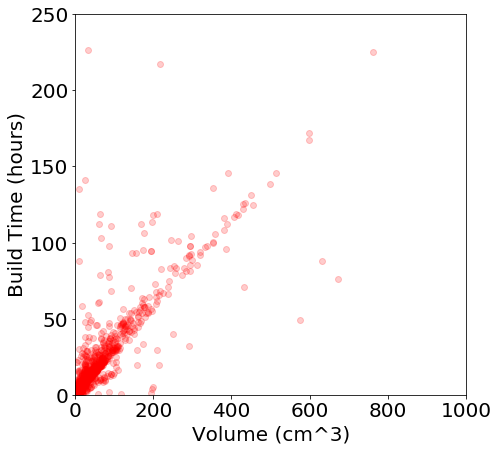

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd_train.Vmes,sd_train.t/60, color='red',marker='o',alpha=0.2)
plt.xlim(1,1000)
plt.ylim(ymin=0,ymax=15000./60)    
plt.xlabel('Extracted Volume (cm^3)')
plt.ylabel('Build Time (hours)')
axes.xaxis.set_tick_params(labelsize=20)
axes.yaxis.set_tick_params(labelsize=20)
axes.set_xlabel('Volume (cm^3)', fontsize=20)
axes.set_ylabel('Build Time (hours)', fontsize=20)
fig.savefig(outdir+'/'+'Vmes_vs_t.png')

## Overhang

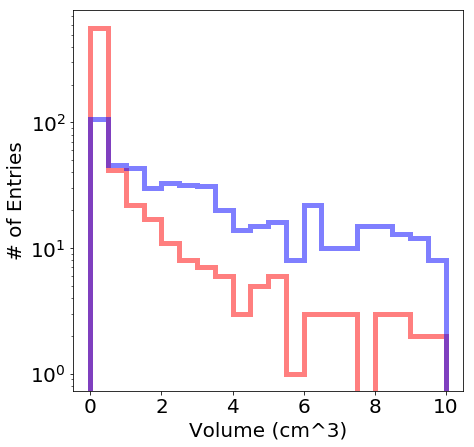

In [6]:
labels=(sd.Vsup<0.1)
len(labels)
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
h1=plt.hist(sd_train.Vangover[labels],20,(0,10),color='red',alpha=0.5,label='has support material', histtype='step', stacked=False, fill=False,linewidth=5)
h2=plt.hist(sd_train.Vangover[~labels],20,(0,10),color='blue',alpha=0.5,label='no support material', histtype='step', stacked=False, fill=False, linewidth=5)
#plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel('# of Entries')
plt.xlabel('Volume Below Overhang (cm^3)')
axes.xaxis.set_tick_params(labelsize=20)
axes.yaxis.set_tick_params(labelsize=20)
axes.set_xlabel('Volume (cm^3)', fontsize=20)
axes.set_ylabel('# of Entries', fontsize=20)
plt.savefig(outdir+'/Vangover_sup0_vs_sup1.png')

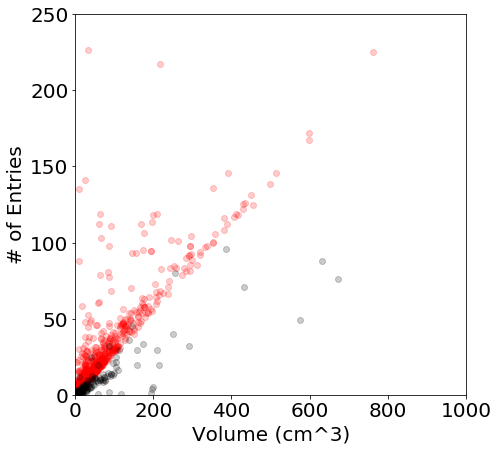

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
cut=(sd_train.Vmes/sd_train.Vfil<1.1)
axes.scatter(sd_train.Vmes[cut],sd_train.t[cut]/60, color='red',marker='o',alpha=0.2)
cut=(sd_train.Vmes/sd_train.Vfil>1.1)
axes.scatter(sd_train.Vmes[cut],sd_train.t[cut]/60, color='black',marker='o',alpha=0.2)
plt.xlim(1,1000)
plt.ylim(ymin=0,ymax=15000./60)
axes.xaxis.set_tick_params(labelsize=20)
axes.yaxis.set_tick_params(labelsize=20)
axes.set_xlabel('Volume (cm^3)', fontsize=20)
axes.set_ylabel('# of Entries', fontsize=20)
fig.savefig(outdir+'/'+'Vmes_vs_t_cutVmesvsVfil.png')

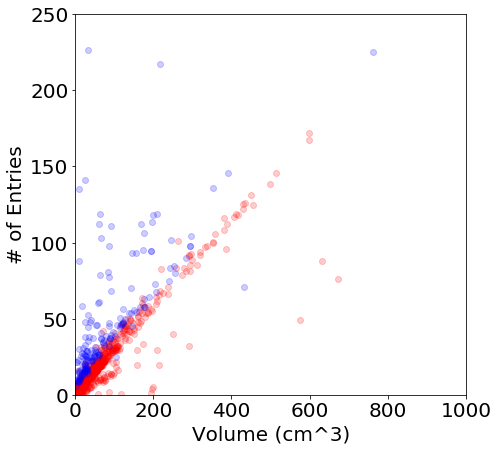

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
cut=(sd_train.Vsup<10)
axes.scatter(sd_train.Vmes[cut],sd_train.t[cut]/60, color='red',marker='o',alpha=0.2)
cut=(sd_train.Vsup>10)
axes.scatter(sd_train.Vmes[cut],sd_train.t[cut]/60, color='blue',marker='o',alpha=0.2)
plt.xlim(1,1000)
plt.ylim(ymin=0,ymax=15000./60)    
axes.xaxis.set_tick_params(labelsize=20)
axes.yaxis.set_tick_params(labelsize=20)
axes.set_xlabel('Volume (cm^3)', fontsize=20)
axes.set_ylabel('# of Entries', fontsize=20)
fig.savefig(outdir+'/'+'Vmes_vs_t_cutVmesvsVfil_cutVsup.png')

Regression TrainData_basic6var_huber --- 1822 entries
992.123558733
[ 1651.87055217   129.12287067    -9.24316724   117.61369772    -2.91748149
    54.76065302]
residual standard error (rse): 1791.37531189 residual mean_absolute_error: 296.749612594 residual mad 44.7489588085 296.749612594 <y>:  1116.30731797
ratio (err):  0.26583146757
R^2 score:  0.510483850612


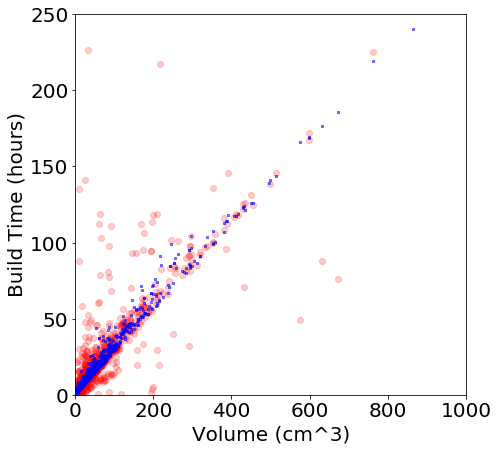

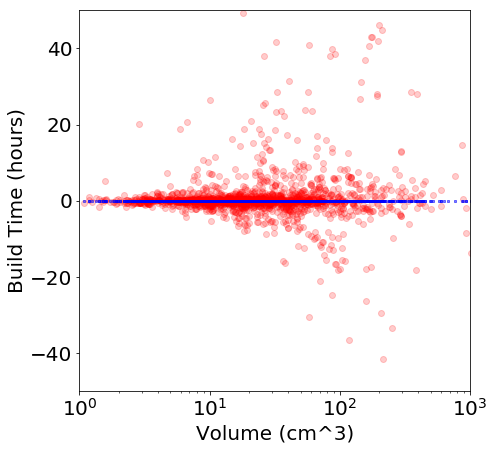

In [9]:
import TDPPredictor
reload(TDPPredictor)
from TDPPredictor import TDPRegressor as tdr
lregtrain_basic = tdr(sd_train[['Vmes','Vch','Vbb','Sa','X','Z']].as_matrix(),sd_train['t'].as_matrix(),'huber',"TrainData_basic6var")
lregtrain_basic.transform()
lregtrain_basic.fit()
lregtrain_basic.predict()
lregtrain_basic.PlotPerformance(1,1000,'log',False)
lregtrain_basic.export_model()

Regression TrainData_6var_ols --- 1822 entries
1116.30731797
[ 1285.32050173   800.12988407    15.67232833  -288.49016609   -97.20751646
   588.15964116]
residual standard error (rse): 1639.99447573 residual mean_absolute_error: 408.231465479 residual mad 122.034399174 408.231465479 <y>:  1116.30731797
ratio (err):  0.365698100254
R^2 score:  0.589721626622


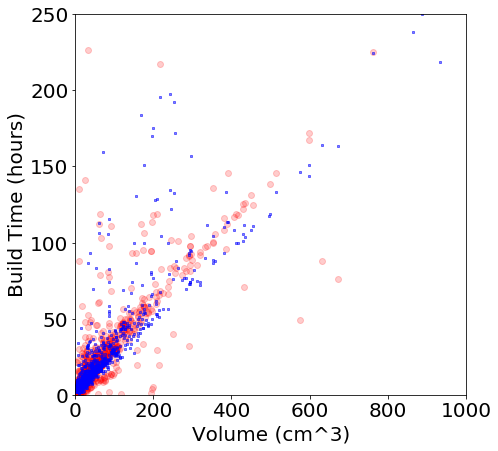

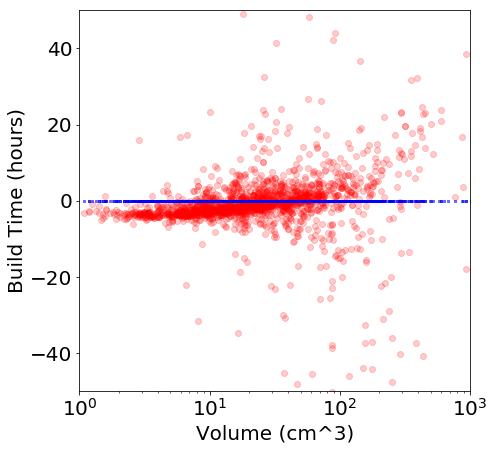

In [10]:
import TDPPredictor
reload(TDPPredictor)
from TDPPredictor import TDPRegressor as tdr
lregtrain_ols = tdr(sd_train[['Vmes','Vch','Vbb','Sa','Z','Vangover']].as_matrix(),sd_train['t'].as_matrix(),'ols',"TrainData_6var")
lregtrain_ols.transform()
lregtrain_ols.fit()
lregtrain_ols.predict()
lregtrain_ols.PlotPerformance(1,1000,'log',False)

Regression TrainData_6var_huber --- 1822 entries
1037.86296686
[ 1675.44116831    90.71290513   -33.26314228    98.92587508    40.5894452
   353.17047462]
residual standard error (rse): 1710.71787342 residual mean_absolute_error: 278.808799525 residual mad 35.8888612444 278.808799525 <y>:  1116.30731797
ratio (err):  0.249759895898
R^2 score:  0.553572807237


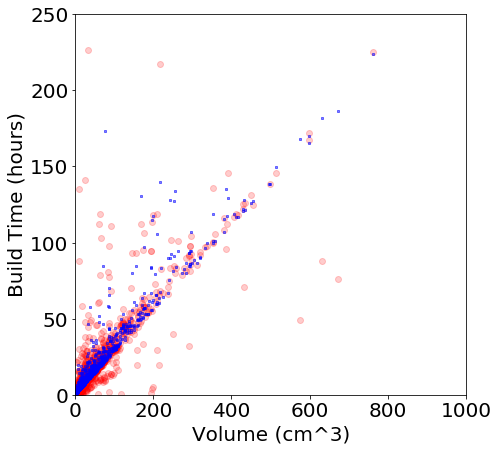

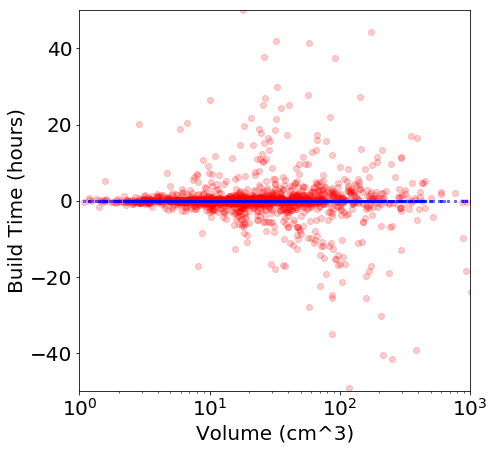

In [11]:
lregtrain = tdr(sd_train[['Vmes','Vch','Vbb','Sa','Z','Vangover']].as_matrix(),sd_train['t'].as_matrix(),'huber',"TrainData_6var")
lregtrain.transform()
lregtrain.fit()
lregtrain.predict()
lregtrain.PlotPerformance(1,1000,'log',False)

## Test

Regression TestData_6var_ols --- 911 entries
residual standard error (rse): 5034.20502993 residual mean_absolute_error: 823.054047508 residual mad 71.5805850571 823.054047508 <y>:  975.963757775
ratio (err):  0.843324396988
R^2 score:  -6.30390719349


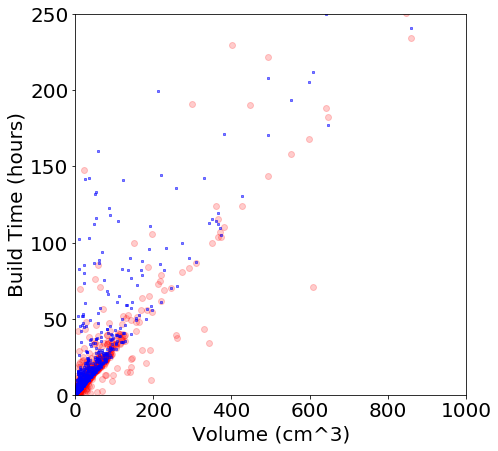

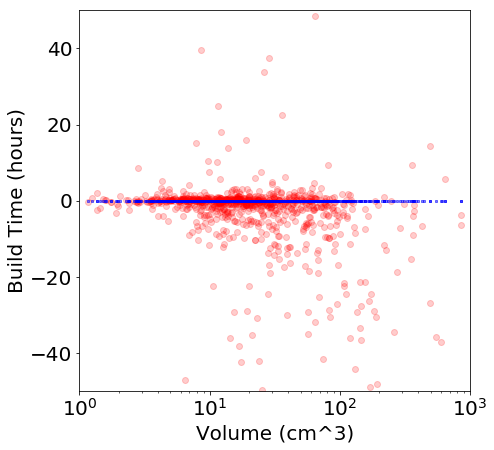

In [12]:
lregtest_ols = tdr(sd_test[['Vmes','Vch','Vbb','Sa','Z','Vangover']].as_matrix(),sd_test['t'].as_matrix(),'ols',"TestData_6var")
lregtest_ols.scaler = lregtrain_basic.scaler
lregtest_ols.regr = lregtrain_basic.regr
lregtest_ols.transform()
lregtest_ols.predict()
lregtest_ols.PlotPerformance(1,1000,'log',False)

Regression TestData_6var_huber --- 911 entries
residual standard error (rse): 966.110110014 residual mean_absolute_error: 224.980191823 residual mad 35.3137374157 224.980191823 <y>:  975.963757775
ratio (err):  0.230521051658
R^2 score:  0.731003455278


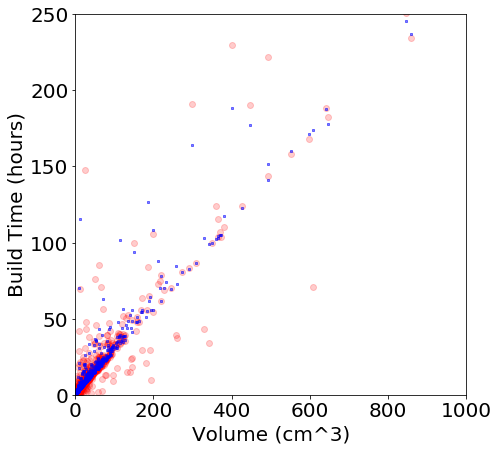

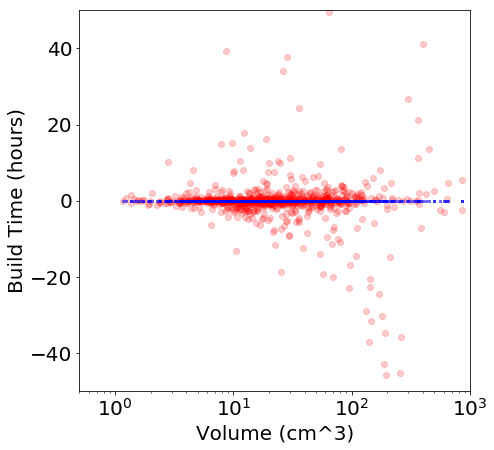

In [13]:
lregtest = tdr(sd_test[['Vmes','Vch','Vbb','Sa','Z','Vangover']].as_matrix(),sd_test['t'].as_matrix(),'huber',"TestData_6var")
lregtest.scaler = lregtrain.scaler
lregtest.regr = lregtrain.regr
lregtest.transform()
lregtest.predict()
lregtest.PlotPerformance(0.5,1000,'log',False)

## Cross-Validation

In [14]:
reload(TDPPredictor)
from TDPPredictor import TDPRegressor as tdr
from TDPPredictor import TDPClassifier as tdc

from sklearn.model_selection import KFold
kf = KFold(n_splits=8)
print kf.get_n_splits(lregtrain.X)
print(kf)

8
KFold(n_splits=8, random_state=None, shuffle=False)


================================ Fold 0
Regression cv_train_all_f0_huber --- 2391 entries
1017.56147529
[ 1663.3255829    135.94737009   -46.60581913    87.19377811    37.71555253
   388.62634155]
Regression cv_test_all_f0_huber --- 342 entries
residual standard error (rse): 648.427995773 residual mean_absolute_error: 186.937748606 residual mad 32.429569187 186.937748606 <y>:  1012.14429825
ratio (err):  0.184694760352
R^2 score:  0.839521855703
================================ Fold 1
Regression cv_train_all_f1_huber --- 2391 entries
1003.45823203
[ 1639.78647722   132.75063414   -40.4387201     88.88838765    39.10514559
   366.21630551]
Regression cv_test_all_f1_huber --- 342 entries
residual standard error (rse): 2304.68086445 residual mean_absolute_error: 308.947359888 residual mad 37.4640080979 308.947359888 <y>:  1173.52153996
ratio (err):  0.263265180372
R^2 score:  0.413843531585
================================ Fold 2
Regression cv_train_all_f2_huber --- 2391 entries
1020.6731

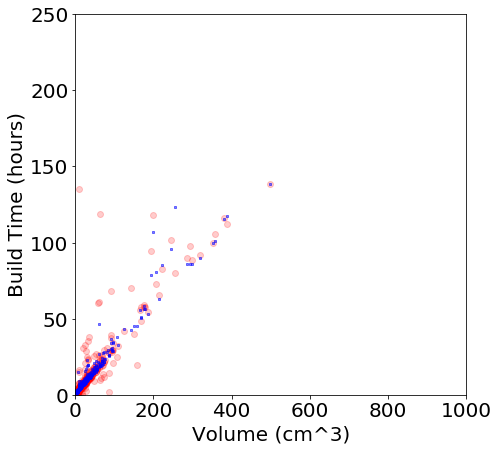

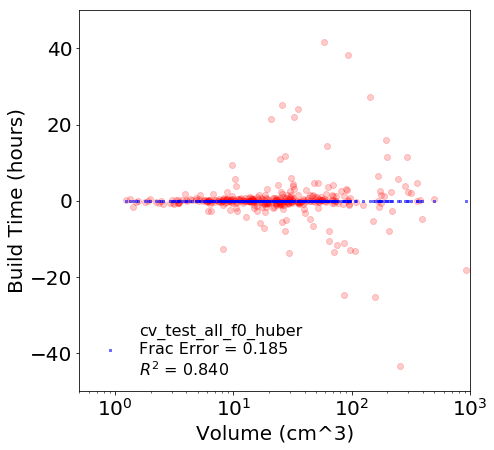

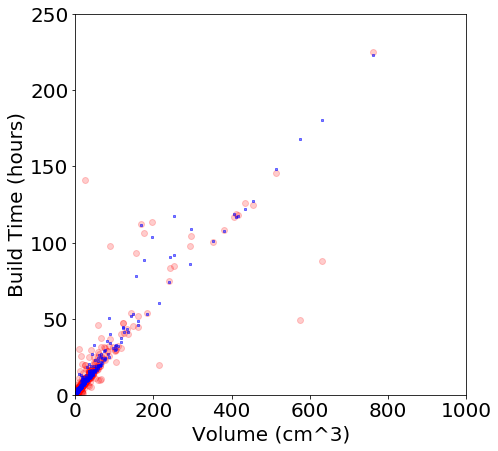

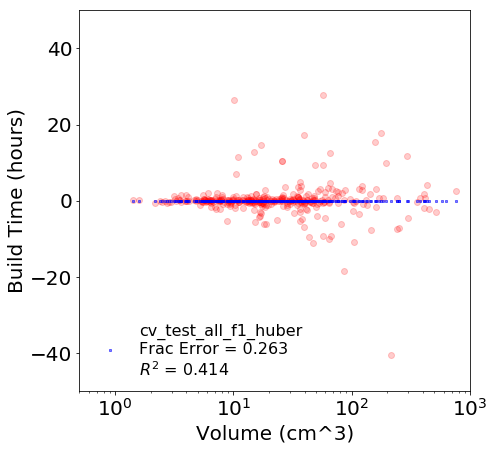

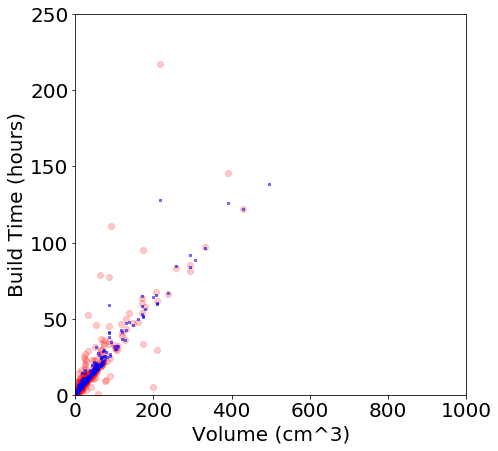

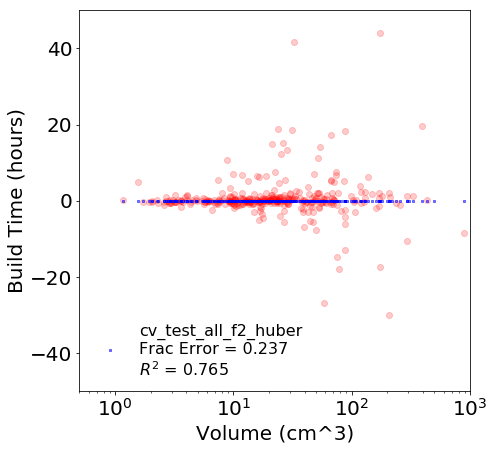

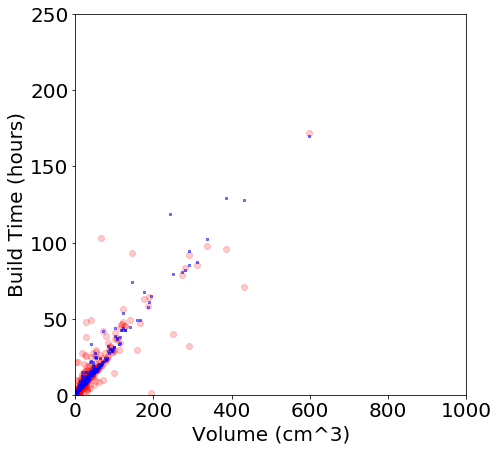

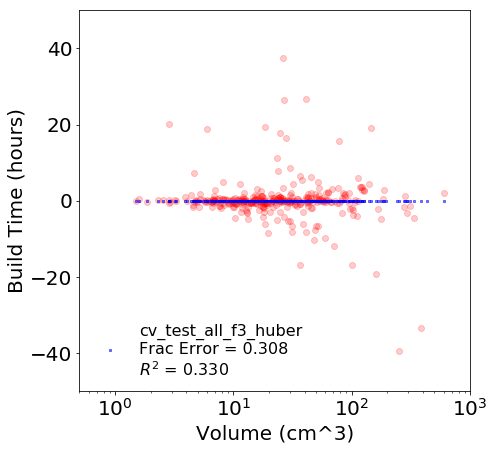

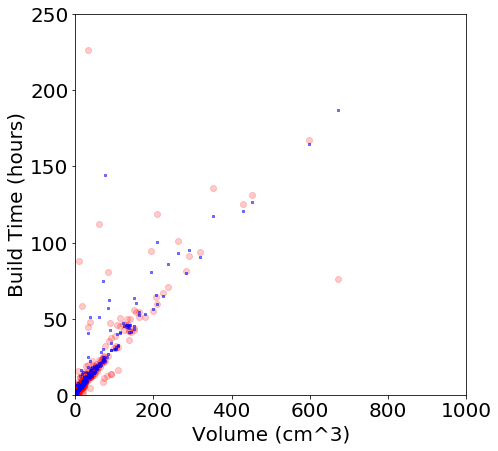

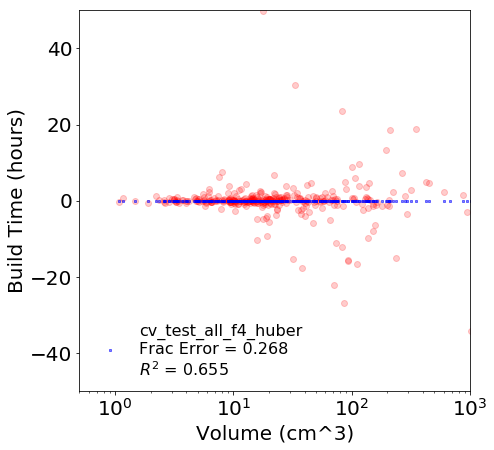

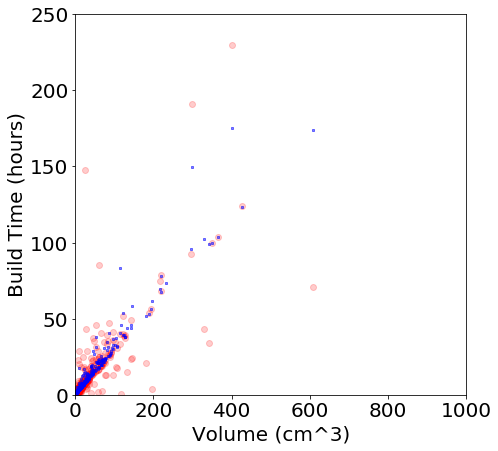

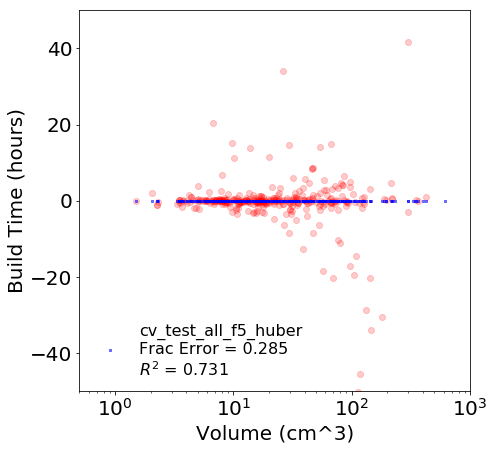

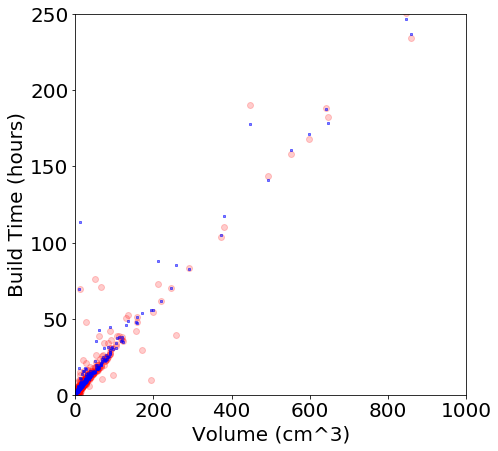

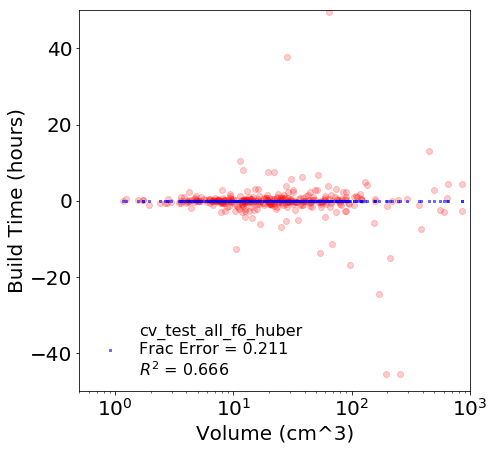

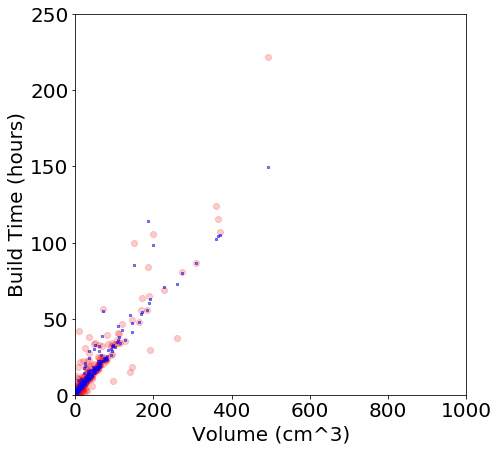

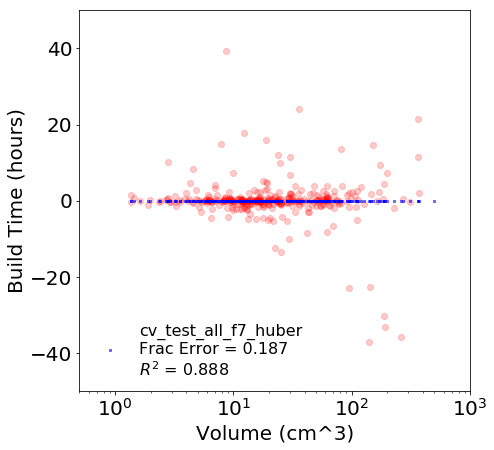

In [21]:
len(sd_test_train)
X_cv = sd_test_train[['Vmes','Vch','Vbb','Sa','Z','Vangover']].as_matrix()
#X_cv = sd_test_train[['Vmes','Vch','Vbb','Sa','Z','X']].as_matrix()
y_cv = sd_test_train['t'].as_matrix()

ct=0
err_all=[]
r2_all=[]
err_sup0=[]
r2_sup0=[]
err_sup1=[]
r2_sup1=[]

for train_index, test_index in kf.split(X_cv):
    print '================================ Fold',ct
    #print("TRAIN:", train_index, "TEST:", test_index)


    # first train combined dataset
    X_all_cv_train, X_all_cv_test = X_cv[train_index], X_cv[test_index]
    y_all_cv_train, y_all_cv_test = y_cv[train_index], y_cv[test_index]
    
    regr_cv_train_all = tdr(X_all_cv_train,y_all_cv_train,'huber','cv_train_all_f%d'%ct)
    regr_cv_train_all.transform()
    regr_cv_train_all.fit()

    regr_cv_test_all = tdr(X_all_cv_test,y_all_cv_test,'huber','cv_test_all_f%d'%ct)
    regr_cv_test_all.scaler = regr_cv_train_all.scaler
    regr_cv_test_all.regr = regr_cv_train_all.regr
    regr_cv_test_all.transform()
    regr_cv_test_all.predict()
    regr_cv_test_all.PlotPerformance(0.5,1000,'log')
    err_all.append(regr_cv_test_all.frac_ame)
    r2_all.append(regr_cv_test_all.R2)

    ct=ct+1

0.242893947258
0.661286564218


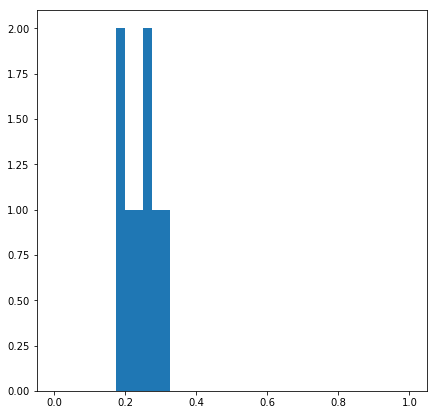

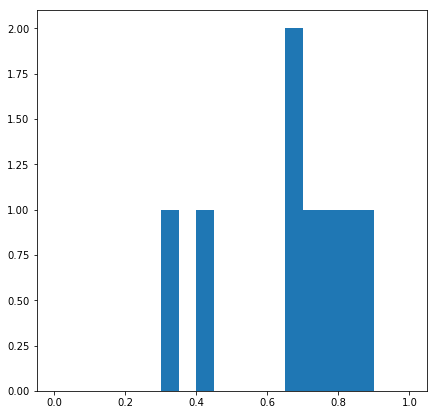

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
print np.mean(err_all)
h=plt.hist(err_all,40,(0,1))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
print np.mean(r2_all)
h=plt.hist(r2_all,20,(0,1))

In [23]:
ct=0
err_all=[]
r2_all=[]
err_sup0=[]
r2_sup0=[]
err_sup1=[]
r2_sup1=[]

#X_clf_cv = sd_test_train[['Vangover','diffVchVmes','Sa']].as_matrix()
X_clf_cv = sd_test_train[['Vangover','diffVchVmes']].as_matrix()
#X_clf_cv = sd_test_train[['Vsup']].as_matrix()
y_clf_cv = ((sd_test_train['Vsup']>0.1).as_matrix()).astype(np.float)

for train_index, test_index in kf.split(X_clf_cv):
    print '================================ Fold',ct
    # now train classifier
    X_clf_train, X_clf_test = X_clf_cv[train_index], X_clf_cv[test_index]
    y_clf_train, y_clf_test = y_clf_cv[train_index], y_clf_cv[test_index]
    print len(X_clf_train),len(y_clf_train),len(X_clf_test),len(y_clf_test)
    clf_cv_train =tdc(X_clf_train,y_clf_train)
    clf_cv_train.transform()
    clf_cv_train.fit()
    clf_cv_train.predict()
    # now test classifier
    clf_cv_test =tdc(X_clf_test,y_clf_test)
    clf_cv_test.clf = clf_cv_train.clf
    clf_cv_test.scaler = clf_cv_train.scaler
    clf_cv_test.transform()
    clf_cv_test.predict()
    
    # regression
    X_train, X_test = X_cv[train_index], X_cv[test_index]
    y_train, y_test = y_cv[train_index], y_cv[test_index]
    # train and test for no support volume
    regr_cv_train_sup0 = tdr(X_train[clf_cv_train.yhat==0],y_train[clf_cv_train.yhat==0],'huber','cv_train_sup0_f%d'%ct)
    regr_cv_train_sup0.transform()
    regr_cv_train_sup0.fit()

    regr_cv_test_sup0 = tdr(X_test[clf_cv_test.yhat==0],y_test[clf_cv_test.yhat==0],'huber','cv_test_sup0_f%d'%ct)
    if len(regr_cv_test_sup0.X) < 10:
        continue
    regr_cv_test_sup0.scaler = regr_cv_train_sup0.scaler
    regr_cv_test_sup0.regr = regr_cv_train_sup0.regr
    regr_cv_test_sup0.transform()
    regr_cv_test_sup0.predict()
    #regr_cv_test_sup0.PlotPerformance(0.5,1000,'log')
    err_sup0.append(regr_cv_test_sup0.frac_ame)
    r2_sup0.append(regr_cv_test_sup0.R2)

    #now train and test regression for with support volume
    regr_cv_train_sup1 = tdr(X_train[clf_cv_train.yhat==1],y_train[clf_cv_train.yhat==1],'huber','cv_train_sup1_f%d'%ct)
    regr_cv_train_sup1.transform()
    regr_cv_train_sup1.fit()

    regr_cv_test_sup1 = tdr(X_test[clf_cv_test.yhat==1],y_test[clf_cv_test.yhat==1],'huber','cv_test_sup1_f%d'%ct)
    if len(regr_cv_test_sup1.X) < 10:
        continue
    regr_cv_test_sup1.scaler = regr_cv_train_sup1.scaler
    regr_cv_test_sup1.regr = regr_cv_train_sup1.regr
    regr_cv_test_sup1.transform()
    regr_cv_test_sup1.predict()
    #regr_cv_test_sup1.PlotPerformance(0.5,1000,'log')
    err_sup1.append(regr_cv_test_sup1.frac_ame)
    r2_sup1.append(regr_cv_test_sup1.R2)

    ct=ct+1

================================ Fold 0
2391 2391 342 342
Classifier train --- 2391 entries
[ 1.26204054]
[[ 6.97197114  0.26296586]]
[[836 164]
 [403 988]]
Classifier train --- 342 entries
[[115  27]
 [ 56 144]]
Regression cv_train_sup0_f0_huber --- 1239 entries
421.75274649
[ 582.76430523   43.03568795  -15.32765091   22.6404306    16.49328371
    6.56366847]
Regression cv_test_sup0_f0_huber --- 171 entries
residual standard error (rse): 627.667058978 residual mean_absolute_error: 106.255791934 residual mad 20.0868748601 106.255791934 <y>:  533.211403509
ratio (err):  0.19927516785
R^2 score:  0.59536436694
Regression cv_train_sup1_f0_huber --- 1152 entries
1650.94477401
[ 2226.3477161    118.63122431   -45.11982976   135.03002945    45.99494357
   518.2845266 ]
Regression cv_test_sup1_f0_huber --- 171 entries
residual standard error (rse): 662.490330967 residual mean_absolute_error: 265.282574182 residual mad 68.9456328935 265.282574182 <y>:  1491.07719298
ratio (err):  0.1779133739

0.19790244963
0.647304707548
0.254273371306
0.637128027465


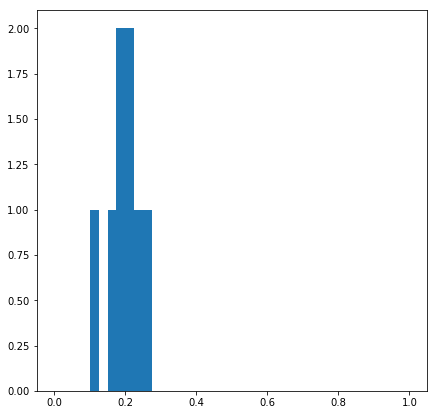

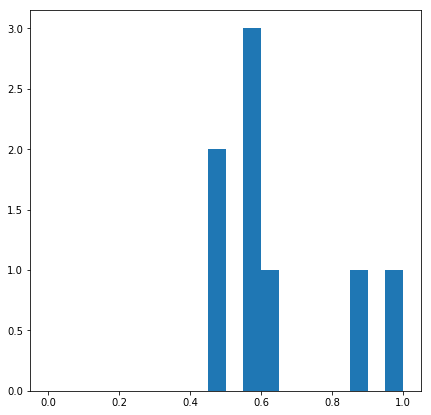

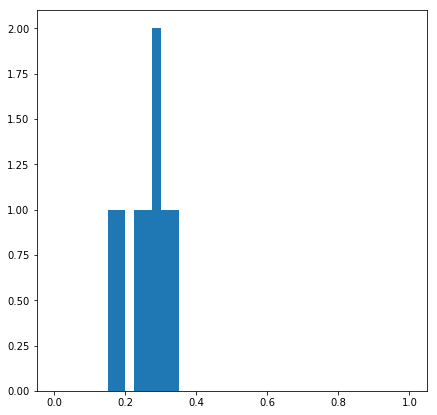

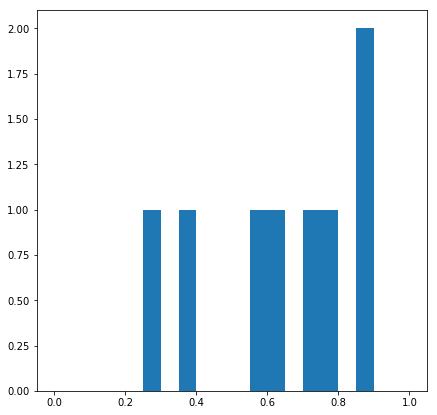

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
print np.mean(err_sup0)
h=plt.hist(err_sup0,40,(0,1))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
print np.mean(r2_sup0)
h=plt.hist(r2_sup0,20,(0,1))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
print np.mean(err_sup1)
h=plt.hist(err_sup1,40,(0,1))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
print np.mean(r2_sup1)
h=plt.hist(r2_sup1,20,(0,1))